In [2]:
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import sys
import time
import pandas as pd
import cv2
import os
import imageio
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import shutil

from deepcell.utils.tracking_utils import load_trks

/opt/conda/lib/python3.7/site-packages/tensorflow-2.5.0-py3.7-linux-x86_64.egg/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# Make mask .npy

### Functions

In [3]:
# Function - make dorsal ventral coordinates ==> d_x, d_y, v_x, v_y

def make_dorsal_ventral_coor(dorsal, ventral, skeleton_id):
    d_x = []
    d_y = []
    v_x = []
    v_y = []

    for each in dorsal[skeleton_id][:]:
        d_x.append(each[0]/12.4)
        d_y.append(each[1]/12.4)

    for each in ventral[skeleton_id][:]:
        v_x.append(each[0]/12.4)
        v_y.append(each[1]/12.4)
    
    return d_x, d_y, v_x, v_y

In [4]:
def make_mask(d_x, d_y, v_x, v_y, well, worm_index):
    polygon = []

    x_i = 0
    while x_i < len(d_x):
        polygon.append(d_x[x_i])
        polygon.append(d_y[x_i])
        x_i += 1

    y_i = len(v_x)-1
    while y_i >= 0:
        polygon.append(v_x[y_i])
        polygon.append(v_y[y_i])
        y_i -= 1

    width = 3600
    height = 3036

    img = Image.new('L', (width, height), 0)
    ImageDraw.Draw(img).polygon(polygon, outline=worm_index, fill=worm_index)
    
    # Define well coordinates
    if well == 'D4':
        mask = np.array(img)[180:710, 160:690]  
    elif well == 'D3':
        mask = np.array(img)[180:710, 880:1410]  
    elif well == 'D2':
        mask = np.array(img)[180:710, 1600:2130]
    elif well == 'D1':
        mask = np.array(img)[180:710, 2320:2850]
    elif well == 'C4':
        mask = np.array(img)[895:1425, 160:690]
    elif well == 'C3':
        mask = np.array(img)[895:1425, 880:1410]
    elif well == 'C2':
        mask = np.array(img)[895:1425, 1600:2130]
    elif well == 'C1':
        mask = np.array(img)[895:1425, 2320:2850]
    elif well == 'B4':
        mask = np.array(img)[1620:2150, 160:690] 
    elif well == 'B3':
        mask = np.array(img)[1620:2150, 880:1410] 
    elif well == 'B2':
        mask = np.array(img)[1620:2150, 1600:2130] 
    elif well == 'B1':
        mask = np.array(img)[1620:2150, 2320:2850] 
    elif well == 'A4':
        mask = np.array(img)[2340:2870, 180:710]
    elif well == 'A3':
        mask = np.array(img)[2340:2870, 880:1410]
    elif well == 'A2':
        mask = np.array(img)[2340:2870, 1600:2130]
    elif well == 'A1':
        mask = np.array(img)[2340:2870, 2320:2850] 
        
    mask_cp = np.copy(mask)
    mask_cp = mask_cp.astype(np.uint16)
    if worm_index != 255:
        mask_cp[mask_cp >= 255] = worm_index
        
    return mask_cp

In [8]:
# function - create 9002*530*530 mask for each well

def make_well_mask(well='A4', dorsal=dorsal, ventral=ventral, well_dict=well_dict, filename=False, down_sampling=1, frame_start=0, frame_end=9001):  
    pd = traj.loc[well_dict[well], :]  # So here it is the position_index, not skel_id
    list_stack = []
    start_time = time.time()
    array_2d = np.zeros(shape=(530, 530), dtype=np.int16)
    
    print("--------------------%s------------------------" % well)

    ## Second, do frame by frame
    frame_index = frame_start
    while frame_index <= frame_end:  
        array_2d = np.zeros(shape=(530, 530), dtype=np.int16)
        skel_id_inframe = list(pd[pd["frame_number"] == frame_index]['skeleton_id'])
        worm_id_inframe = list(pd[pd["frame_number"] == frame_index]['worm_index_joined'])

        for i, skel_id in enumerate(skel_id_inframe):
            worm_index = worm_id_inframe[i]
            dx, dy, vx, vy = make_dorsal_ventral_coor(dorsal, ventral, skel_id)
            mask = make_mask(dx, dy, vx, vy, well, worm_index)
            array_2d = array_2d + mask

        list_stack.append(array_2d)

        if frame_index == frame_start:
            print("Starts at: ", frame_index)
        
        if frame_index%200 == 0:
            print("Finish frame_index: ", frame_index)
            print("--- %s seconds ---" % (time.time() - start_time))

        if frame_index == frame_end:
            print("Finish!")
            print("--- %s seconds ---" % (time.time() - start_time))

        frame_index += 1
    print("length of list_stack: ", len(list_stack))
    stacked_array = np.stack(list_stack, axis=0)
    stacked_array = stacked_array[:,:,:, np.newaxis]
    
    if filename:
        output_filename = filename
    else:
        output_filename = "worm_data/22956814/mask_%s.npy" % well
    
    if down_sampling != 1:
        stacked_array = stacked_array[frame_start:(frame_end+1):down_sampling, :, :, :]
    
    np.save(output_filename, stacked_array)
    
    return stacked_array

### Create variables

In [6]:
# Input file
fN = h5py.File("../22956814_featuresN.hdf5")

# Define dorsal and ventral coordinates
coordinates = fN['coordinates']
dorsal = coordinates['dorsal_contours']
ventral = coordinates['ventral_contours']

# trajectory_data and timeseries_data
traj = pd.read_hdf("../22956814_featuresN.hdf5", '/trajectories_data')
timeseries = fN['timeseries_data']

In [7]:
# Get wells - data from timeseries_data, at position [2]

wells = ['A1', 'A2', 'A3', 'A4', 'B1', 'B2', 'B3', 'B4', 'C1', 'C2', 'C3', 'C4', 'D1', 'D2', 'D3', 'D4']
#wells = [each.encode() for each in wells]

well_dict = {}
for each in wells:
    well_dict[each] = []
    
#print('A1'.encode().decode())
for i, each in enumerate(timeseries[:]):  # "i" == index
    well = each[2].decode()
    if well in well_dict.keys():
        well_dict[well].append(i)

### Create mask .npy

##### Well A1

In [9]:
import random

In [30]:
pd= traj.loc[well_dict['A1'], :]
worm_ids = pd['worm_index_joined']
unique_worm_ids = list(np.unique(worm_ids))  

In [39]:
unique_worm_ids

[9, 1533, 1783, 1787, 1792, 1799, 1845, 4500, 5980]

In [68]:
# Find the first frame for the above worm to appear:
frame_starts_a1 = []
for worm in unique_worm_ids:
    frame_starts_a1.append(list(pd[pd['worm_index_joined'] == worm]['frame_number'])[0])

In [69]:
frame_starts_a1

[0, 2275, 2650, 2651, 2659, 2669, 2715, 6700, 8950]

In [70]:
# Also create 5 random.randint between 1,10 for down_sampling:

random_down_sampling = [random.randint(1, 10) for x in range(len(unique_worm_ids))]
print(random_down_sampling)

[6, 6, 6, 4, 7, 10, 7, 1, 5]


In [71]:
# [0]

down_sampling = random_down_sampling[0]
frame_start = frame_starts_a1[0]
frame_end = frame_start + 100*down_sampling -1

a1_m1 = make_well_mask('A1', down_sampling=down_sampling, frame_start=frame_start, frame_end=frame_end, filename='../22956814/a1_mask_1.npy')

--------------------A1------------------------
Starts at:  0
Finish frame_index:  0
--- 0.015425443649291992 seconds ---
Finish frame_index:  200
--- 2.755995035171509 seconds ---
Finish frame_index:  400
--- 5.312572717666626 seconds ---
Finish!
--- 7.86336088180542 seconds ---
length of list_stack:  600


In [72]:
np.unique(a1_m1)  # check unique!! 

array([0, 9], dtype=int32)

In [92]:
# [1] fails...
# [2] fails...
# [3] fails...
# [4] fails...
# [5] fails...
# [6] fails...
# [7] good !! (the last)

down_sampling = random_down_sampling[7]
frame_start = frame_starts_a1[7]
frame_end = frame_start + 100*down_sampling -1

a1_m2 = make_well_mask('A1', down_sampling=down_sampling, frame_start=frame_start, frame_end=frame_end, filename='../22956814/a1_mask_2.npy')

--------------------A1------------------------
Starts at:  6700
Finish!
--- 1.652681589126587 seconds ---
length of list_stack:  100


In [93]:
np.unique(a1_m2)  # check unique!! 

array([   0, 4500], dtype=int32)

In [ ]:
a1_full = make_well_mask('A1', down_sampling=100, frame_start=0, frame_end=9002, filename='../22956814/a1_mask.npy')

In [107]:
# Note down the positions
with open("../22956814/a1_not_empty.txt", "w") as f:
    f.write(str(0) + ',' + str(599) + ',' + str(6) + '\n')
    f.write(str(6700) + ',' + str(6799) + ',' + str(1))

#### Well A2

In [95]:
pd= traj.loc[well_dict['A2'], :]
worm_ids = pd['worm_index_joined']
unique_worm_ids = list(np.unique(worm_ids)) 
print(unique_worm_ids)

# Find the first frame for the above worm to appear:
frame_starts_a2 = []
for worm in unique_worm_ids:
    frame_starts_a2.append(list(pd[pd['worm_index_joined'] == worm]['frame_number'])[0])
print(frame_starts_a2)

# Also create random.randint between 1,10 for down_sampling:
random_down_sampling_a2 = [random.randint(1, 10) for x in range(len(unique_worm_ids))]
print(random_down_sampling_a2)

[7, 8, 223, 344, 354, 412, 545, 572, 577, 650, 703, 707, 716, 1241, 1278, 1338, 1351, 1361, 1367, 1406, 1730, 1768, 2121, 2678, 3127, 3150, 3164, 3189, 3224, 3342, 3346, 3364, 3676, 3979, 5325, 5550, 5696, 5792]
[0, 0, 300, 510, 525, 615, 850, 890, 896, 1000, 1078, 1088, 1107, 1875, 1925, 2000, 2019, 2029, 2046, 2076, 2575, 2625, 3150, 4000, 4750, 4772, 4800, 4825, 4875, 5068, 5073, 5100, 5575, 6000, 7950, 8250, 8475, 8625]
[7, 10, 4, 7, 8, 1, 1, 6, 6, 5, 5, 9, 9, 9, 8, 3, 2, 1, 10, 5, 4, 6, 7, 5, 3, 8, 3, 3, 4, 10, 6, 7, 2, 1, 2, 4, 3, 1]


In [100]:
a2_not_empty = []
rename_flag = 1

for i, start in enumerate(frame_starts_a2):
    frame_start = start
    down_sampling = random_down_sampling_a2[i]
    frame_end = start + 100*down_sampling - 1
    fn = '../22956814/a2_mask_%d.npy' % (i+1)  # '+1' to avoid rewriting the next file!!!!
    
    a2_array = make_well_mask('A2', down_sampling=down_sampling, frame_start=frame_start, frame_end=frame_end, filename=fn)
    if a2_array.size == 0:
        os.remove(fn)
    else:
        start_end_sampling = [frame_start, frame_end, down_sampling]  # For sampling raw video
        a2_not_empty.append(start_end_sampling)
        os.rename(fn, '../22956814/a2_mask_%d.npy' % rename_flag)  # Rename the file so that 1,2....n
        rename_flag += 1
        

--------------------A2------------------------
Starts at:  0
Finish frame_index:  0
--- 0.030622482299804688 seconds ---
Finish frame_index:  200
--- 2.884459972381592 seconds ---
Finish frame_index:  400
--- 7.303804874420166 seconds ---
Finish frame_index:  600
--- 15.800716876983643 seconds ---
Finish!
--- 18.66941261291504 seconds ---
length of list_stack:  700
--------------------A2------------------------
Starts at:  0
Finish frame_index:  0
--- 0.026495933532714844 seconds ---
Finish frame_index:  200
--- 2.915476083755493 seconds ---
Finish frame_index:  400
--- 6.991531133651733 seconds ---
Finish frame_index:  600
--- 12.738094091415405 seconds ---
Finish frame_index:  800
--- 18.4087872505188 seconds ---
Finish!
--- 24.640509843826294 seconds ---
length of list_stack:  1000
--------------------A2------------------------
Starts at:  300
Finish frame_index:  400
--- 2.790583372116089 seconds ---
Finish frame_index:  600
--- 8.672608137130737 seconds ---
Finish!
--- 11.57709193

In [103]:
# IMPORTANT!!! Don't forget to store the not_empty_list as a .txt!!!!!!!

with open('../22956814/a2_not_empty.txt', 'w') as f:
    for each in a2_not_empty[0:-1]:
        f.write(str(each[0]) + ',' + str(each[1]) + ',' + str(each[2]) + '\n')
    f.write(str(a2_not_empty[-1][0]) + ',' + str(a2_not_empty[-1][1]) + ',' + str(a2_not_empty[-1][2]))

#### Well A3

In [109]:
pd= traj.loc[well_dict['A3'], :]
worm_ids = pd['worm_index_joined']
unique_worm_ids = list(np.unique(worm_ids)) 
print(unique_worm_ids)

# Find the first frame for the above worm to appear:
frame_starts_a3 = []
for worm in unique_worm_ids:
    frame_starts_a3.append(list(pd[pd['worm_index_joined'] == worm]['frame_number'])[0])
print(frame_starts_a3)

# Also create random.randint between 1,10 for down_sampling:
random_down_sampling_a3 = [random.randint(1, 10) for x in range(len(unique_worm_ids))]
print(random_down_sampling_a3)

[5, 127, 243, 251, 289, 474, 507, 575, 636, 1052, 1143, 1145, 1189, 1199, 1205, 1277, 1419, 1445, 1458, 1532, 1739, 3324, 3556, 3575, 4522, 4534, 4553, 4732, 4736, 4742, 4773, 5876, 5881]
[0, 150, 331, 357, 425, 725, 775, 893, 981, 1604, 1744, 1750, 1794, 1811, 1815, 1925, 2102, 2143, 2164, 2275, 2585, 5050, 5400, 5425, 6725, 6744, 6756, 7050, 7058, 7075, 7118, 8777, 8795]
[10, 5, 7, 8, 9, 7, 9, 8, 5, 2, 10, 1, 7, 8, 3, 4, 6, 6, 7, 6, 1, 4, 7, 3, 6, 7, 1, 6, 3, 2, 8, 5, 3]


In [110]:
a3_not_empty = []
rename_flag = 1

for i, start in enumerate(frame_starts_a3):
    frame_start = start
    down_sampling = random_down_sampling_a3[i]
    frame_end = start + 100*down_sampling - 1
    fn = '../22956814/a3_mask_%d.npy' % (i+1)  # '+1' to avoid rewriting the next file!!!!
    
    a3_array = make_well_mask('A3', down_sampling=down_sampling, frame_start=frame_start, frame_end=frame_end, filename=fn)
    if a3_array.size == 0:
        os.remove(fn)
    else:
        start_end_sampling = [frame_start, frame_end, down_sampling]  # For sampling raw video
        a3_not_empty.append(start_end_sampling)
        os.rename(fn, '../22956814/a3_mask_%d.npy' % rename_flag)  # Rename the file so that 1,2....n
        rename_flag += 1
        

--------------------A3------------------------
Starts at:  0
Finish frame_index:  0
--- 0.04716634750366211 seconds ---
Finish frame_index:  200
--- 3.0979127883911133 seconds ---
Finish frame_index:  400
--- 6.508500099182129 seconds ---
Finish frame_index:  600
--- 12.381013631820679 seconds ---
Finish frame_index:  800
--- 18.174339056015015 seconds ---
Finish!
--- 23.912564992904663 seconds ---
length of list_stack:  1000
--------------------A3------------------------
Starts at:  150
Finish frame_index:  200
--- 1.022672414779663 seconds ---
Finish frame_index:  400
--- 4.479139804840088 seconds ---
Finish frame_index:  600
--- 10.220179796218872 seconds ---
Finish!
--- 11.557414531707764 seconds ---
length of list_stack:  500
--------------------A3------------------------
Starts at:  331
Finish frame_index:  400
--- 1.5664830207824707 seconds ---
Finish frame_index:  600
--- 7.293754816055298 seconds ---
Finish frame_index:  800
--- 14.878209590911865 seconds ---
Finish frame_inde

In [111]:
# IMPORTANT!!! Don't forget to store the not_empty_list as a .txt!!!!!!!

with open('../22956814/a3_not_empty.txt', 'w') as f:
    for each in a3_not_empty[0:-1]:
        f.write(str(each[0]) + ',' + str(each[1]) + ',' + str(each[2]) + '\n')
    f.write(str(a3_not_empty[-1][0]) + ',' + str(a3_not_empty[-1][1]) + ',' + str(a3_not_empty[-1][2]))

#### Well A4

In [112]:
pd= traj.loc[well_dict['A4'], :]
worm_ids = pd['worm_index_joined']
unique_worm_ids = list(np.unique(worm_ids)) 
print(unique_worm_ids)

# Find the first frame for the above worm to appear:
frame_starts_a4 = []
for worm in unique_worm_ids:
    frame_starts_a4.append(list(pd[pd['worm_index_joined'] == worm]['frame_number'])[0])
print(frame_starts_a4)

# Also create random.randint between 1,10 for down_sampling:
random_down_sampling_a4 = [random.randint(1, 10) for x in range(len(unique_worm_ids))]
print(random_down_sampling_a4)

[3, 60, 79, 94, 258, 398, 764, 1571, 3325]
[0, 1, 43, 75, 375, 600, 1200, 2325, 5050]
[5, 4, 7, 7, 3, 4, 8, 9, 1]


In [113]:
a4_not_empty = []
rename_flag = 1

for i, start in enumerate(frame_starts_a4):
    frame_start = start
    down_sampling = random_down_sampling_a4[i]
    frame_end = start + 100*down_sampling - 1
    fn = '../22956814/a4_mask_%d.npy' % (i+1)  # '+1' to avoid rewriting the next file!!!!
    
    a4_array = make_well_mask('A4', down_sampling=down_sampling, frame_start=frame_start, frame_end=frame_end, filename=fn)
    if a4_array.size == 0:
        os.remove(fn)
    else:
        start_end_sampling = [frame_start, frame_end, down_sampling]  # For sampling raw video
        a4_not_empty.append(start_end_sampling)
        os.rename(fn, '../22956814/a4_mask_%d.npy' % rename_flag)  # Rename the file so that 1,2....n
        rename_flag += 1
        

--------------------A4------------------------
Starts at:  0
Finish frame_index:  0
--- 0.019813060760498047 seconds ---
Finish frame_index:  200
--- 3.4526782035827637 seconds ---
Finish frame_index:  400
--- 5.597827434539795 seconds ---
Finish!
--- 7.043086528778076 seconds ---
length of list_stack:  500
--------------------A4------------------------
Starts at:  1
Finish frame_index:  200
--- 3.509061098098755 seconds ---
Finish frame_index:  400
--- 5.705989837646484 seconds ---
Finish!
--- 5.7065746784210205 seconds ---
length of list_stack:  400
--------------------A4------------------------
Starts at:  43
Finish frame_index:  200
--- 2.8096933364868164 seconds ---
Finish frame_index:  400
--- 4.957847833633423 seconds ---
Finish frame_index:  600
--- 7.097807884216309 seconds ---
Finish!
--- 8.846704244613647 seconds ---
length of list_stack:  700
--------------------A4------------------------
Starts at:  75
Finish frame_index:  200
--- 2.122478723526001 seconds ---
Finish frame

In [114]:
# IMPORTANT!!! Don't forget to store the not_empty_list as a .txt!!!!!!!

with open('../22956814/a4_not_empty.txt', 'w') as f:
    for each in a4_not_empty[0:-1]:
        f.write(str(each[0]) + ',' + str(each[1]) + ',' + str(each[2]) + '\n')
    f.write(str(a4_not_empty[-1][0]) + ',' + str(a4_not_empty[-1][1]) + ',' + str(a4_not_empty[-1][2]))

### Check gif

In [12]:
# Check gif

def plot_gif(np_array, output_fn):
    mpl.rcParams['image.interpolation'] = 'none'  # Prevent mpl smoothes the edges
    os.mkdir("pic_temporary")  # To temporarily store the files

    #spring = cm.get_cmap('spring', 256)
    #newcolors = spring(np.linspace(0, 256, 256))
    #black = np.array([0/256, 0/256, 0/256, 1])
    #newcolors[:1, :] = black
    #newcmp = ListedColormap(newcolors)

    pic_list = []
    flag = 0

    for i in range(np_array.shape[0]):
        #plt.imshow(np_array[i], cmap=newcmp)
        mask = np_array[i]
        mask = np.where(mask==0, -1, mask) 
        #print(np.unique(mask_1))

        value = -1
        masked_array = np.ma.masked_where(mask == value, mask)

        #cmap = mpl.cm.get_cmap("spring")
        cmap = mpl.cm.get_cmap("spring").copy()
        cmap.set_bad(color='black')
        
        plt.imshow(masked_array, cmap=cmap)
        
        fn = 'pic_temporary/%d.jpg' % flag
        plt.savefig(fn)
        pic_list.append(fn)
        flag += 1
    
    with imageio.get_writer(output_fn, mode='I') as writer:
        for filename in pic_list:
            image = imageio.imread(filename)
            writer.append_data(image)
    
    # Remove the temporary file
    shutil.rmtree("pic_temporary")
    
    #return pic_list

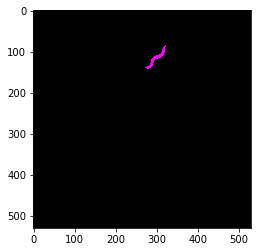

In [94]:
#plot_gif(a1_full, "../22956814/mask_a1.gif")
plot_gif(a1_m2, "../22956814/mask_a1_m2.gif")
#plot_gif(d3_m1, "../22956814/mask_d3_m1.gif")

# Make raw video npy

### Functions

In [ ]:
def get_raw_well(well, well_name='A4', filename=False, down_sampling=False, frame_start=0, frame_end=9001, down_sampling=1, filename=False):    
    print(well_name)
    frames = []
    
    ymin = well[0]
    ymax = well[1]
    xmin = well[2]
    xmax = well[3]

    path = "000000.mp4"
    cap = cv2.VideoCapture(path)
    ret = True
    while ret:
        ret, img = cap.read() # read one frame from the 'capture' object; img is (H, W, C)
        if ret:
            frames.append(img[ymin:ymax, xmin:xmax, :])
    
    stacked = np.stack(frames, axis=0)
    stacked = stacked.astype(dtype='float32')
    stacked_mean = np.mean(stacked, axis=3)[:,:,:,None]
    
    if frame_start != 0 or frame_end != 9001 or down_sampling != 1:
        stacked_mean = stacked_mean[frame_start:(frame_end+1):down_sampling, :, :, :]
    
    if filename:
        output_fn = filename
    else:
        output_fn = 'well_A/raw_%s.npy' % well_name
        
    np.save(output_fn, stacked_mean)
    
    return stacked_mean

### Define well regions

In [ ]:
# get well by well, and store
d4 = [180, 710, 160, 690]
d3 = [180, 710, 880, 1410]
d2 = [180, 710, 1600, 2130]
d1 = [180, 710, 2320, 2850]

c4 = [895, 1425, 160, 690]
c3 = [895, 1425, 880, 1410]
c2 = [895, 1425, 1600, 2130]
c1 = [895, 1425, 2320, 2850]

b4 = [1620, 2150, 160, 690]
b3 = [1620, 2150, 880, 1410]
b2 = [1620, 2150, 1600, 2130]
b1 = [1620, 2150, 2320, 2850]

a4 = [2340, 2870, 160, 690]
a3 = [2340, 2870, 880, 1410]
a2 = [2340, 2870, 1600, 2130]
a1 = [2340, 2870, 2320, 2850]

In [ ]:
get_raw_well(a1, "A1", small=True, down_sampling=False, frame_start=0, frame_end=599, down_sampling=6, filename="22956814/A1_raw_0_599.npy")
#get_raw_well(a1, "A1", small=True, down_sampling=False, frame_start=600, frame_end=1199, down_sampling=6, filename="22956814/A1_raw_600_1199.npy")
#get_raw_well(a1, "A1", small=True, down_sampling=False, frame_start=1200, frame_end=1799, down_sampling=6, filename="22956814/A1_raw_1200_1799.npy")
#get_raw_well(a1, "A1", small=True, down_sampling=False, frame_start=1800, frame_end=2399, down_sampling=6, filename="22956814/A1_raw_1800_2399.npy")
#get_raw_well(a1, "A1", small=True, down_sampling=False, frame_start=2400, frame_end=2999, down_sampling=6, filename="22956814/A1_raw_2400_2999.npy")

### Create raw .npy files

# Make lineages dict

In [48]:
def make_lineages(well, frame_start=0, frame_end=9002):  # TODO: check the unique worm ids within the frame_start and frame_end
    pd= traj.loc[well_dict[well], :]
    worm_ids = pd['worm_index_joined']
    unique_worm_ids = list(np.unique(worm_ids))  
    
    lineages = {}
        
    for worm in unique_worm_ids:
        worm_pd = pd.loc[pd['worm_index_joined'] == worm]
        worm_pd_trim = worm_pd[worm_pd['frame_number'].between(frame_start, frame_end)]
        
        if worm_pd_trim.empty == False:  # So only adds in the worm in the frames    
            lineages[int(worm)] = {}
            
            nested_dict = {}
            nested_dict['label'] = int(worm)
            
            frame_list = []
            for frame in worm_pd_trim['frame_number']:  # TODO: edit here
                frame_list.append(int(frame))
            nested_dict['frames'] = frame_list

            nested_dict['daughters'] = []
            nested_dict['capped'] = False
            nested_dict['frame-div'] = None
            nested_dict['parent'] = None

            lineages[worm] = nested_dict
        
    return lineages